In [1]:
# Download historical period of record SWE and snowdepth up until last night (midnight) for AB snow pillows

In [2]:
%matplotlib inline
#mpld3.enable_notebook()
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
from astropy.io import ascii
import pytz
# OS interaction
import sys
import os
import glob
import wget
import seaborn as sns
sns.set_context("talk",font_scale=1.5)
sns.set_style('whitegrid')

# User config

In [3]:
# Paths to user files
data_dir = os.path.normpath(r'F:\Work\e\Data\Obs\Canada_Project_Sites\CSAS_data') # Where to store data on local computer
git_dir  = os.path.normpath(r'C:\Users\new356\Google Drive\Python\CSAS') # This repo

In [4]:
# Stations we wish to download
sta_code = ['2A21P','05DD804','1A01P','1A17P','1A14P','07BB811','07BB814','05AD803','13A19S','05AA809','05DB802','05BJ805','05BL811','13A27S','05BL812','05CA805','05AA817','05BB803','05BF824']
# Variables we want to download (currently only SW (SWE) and SD (Snow depth))
variables = ['SW','SD']
c_network = 'environmentAlberta'

# Create paths

In [5]:
# Data network
network = 'AB_POR'

# Location to download current AB station data
download_dir = os.path.join(data_dir,network,'current')
# Make if does not exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
    
# Netcdf file to save to
netcdf_dir   = os.path.join(data_dir,network,'netcdf')
# Make if does not exist
if not os.path.exists(netcdf_dir):
    os.makedirs(netcdf_dir)
netcdf_file_out =  os.path.join(netcdf_dir,'AB_SWE_SD_NRT.nc')

# Metadata for AB pillows 
meta_file         = 'AB_Station_Metadata.csv'
meta_file_path    = os.path.join(git_dir,'metadata',meta_file)

# Download AB pillow SWE and SD data, Period-of-record to last midnight

In [6]:
#  example: https://environment.alberta.ca/apps/Basins/data/porExtracts/porExtract_AB_05BB803_SW_Cmd.Cor-Seas.C.csv
url_base  = 'https://environment.alberta.ca/apps/Basins/data/porExtracts/'
file_base = 'porExtract_AB_'
file_ext = '_Cmd.Cor-Seas.C.csv'

In [7]:
os.chdir(download_dir)
Var_names = ['SWE','Snowdepth','AirTemperature','Precipitation']
AB_2_BC_var_dict = {'Value(mm)':Var_names[0],'Value(cm)':Var_names[1]}
Var_units = ['mm','cm','C','mm']
unit_dict = dict(zip(Var_names,Var_units))

In [8]:
# Remove previous files
for cvar in variables:
    for cfile in sta_code:
        try:
            os.remove(file_base+cfile+'_'+cvar+file_ext)
        except OSError:
            pass

In [9]:
# Download newest files
for cvar in variables:
    for csta in sta_code:
        cfile = url_base+file_base+csta+'_'+cvar+file_ext
        print('\r')
        try:
            wget.download(cfile) 
        except OSError:
            print("Could not download "+cvar+" for "+csta)
            pass


Could not download SW for 2A21P

100% [......................................................] 2233709 / 2233709
Could not download SW for 1A01P

Could not download SW for 1A17P

Could not download SW for 1A14P

100% [......................................................] 2448591 / 2448591
100% [......................................................] 4209268 / 4209268
100% [......................................................] 5969177 / 5969177
Could not download SW for 13A19S

100% [......................................................] 5695036 / 5695036
100% [......................................................] 6064165 / 6064165
100% [......................................................] 6382750 / 6382750
100% [......................................................] 5434208 / 5434208
Could not download SW for 13A27S

100% [......................................................] 5260312 / 5260312
100% [......................................................] 5148149 / 5148149

In [10]:
# Import files
ds_var_list = []
for cvar in variables:
    ds_list = []
#     sta_list_used = []
    for (i,csta) in enumerate(sta_code):
        cf = file_base+csta+'_'+cvar+file_ext
        if os.path.isfile(cf):
            print(cf)

            # Load in to python
            dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
            try: # Because sometimes the file exists, but is empty
                df = pd.read_csv(cf,index_col=0, skiprows=23, engine='python', parse_dates={'datetime': ['Date', 'Time']}, date_parser=dateparse)
            except:
                print("Could not parse "+cf+". Something wrong with file format.")
                continue
            df.index.names = ['Time_MST']

            # Rename columns
            df = df.rename(columns = AB_2_BC_var_dict)

            # df to ds
            ds_c = xr.Dataset.from_dataframe(df)
            # Add as coord
            ds_c['staID'] = csta
            ds_c.set_coords('staID',inplace=True)

            # Store as dict (if we have any data)
            if ds_c.Time_MST.size>0:
                ds_list.append(ds_c)
#                 sta_list_used.append(csta)

    # Concat all stations for one variable into netcdf
    ds_var = xr.concat(ds_list,'staID')
    ds_var_list.append(ds_var)

porExtract_AB_05DD804_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_07BB811_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_07BB814_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05AD803_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05AA809_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05DB802_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05BJ805_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05BL811_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05BL812_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05CA805_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05AA817_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05BB803_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05BF824_SW_Cmd.Cor-Seas.C.csv
porExtract_AB_05DD804_SD_Cmd.Cor-Seas.C.csv
Could not parse porExtract_AB_05DD804_SD_Cmd.Cor-Seas.C.csv. Something wrong with file format.
porExtract_AB_05AD803_SD_Cmd.Cor-Seas.C.csv
porExtract_AB_05AA809_SD_Cmd.Cor-Seas.C.csv
porExtract_AB_05AA817_SD_Cmd.Cor-Seas.C.csv
porExtract_AB_05BB803_SD_Cmd.Cor-Seas.C.csv


In [11]:
# Merge ds of different variables together
ds = xr.merge(ds_var_list)
ds

<xarray.Dataset>
Dimensions:    (Time_MST: 315320, staID: 13)
Coordinates:
  * staID      (staID) object '05AA809' '05AA817' '05AD803' '05BB803' ...
  * Time_MST   (Time_MST) datetime64[ns] 1983-12-07T11:40:00 ...
Data variables:
    SWE        (staID, Time_MST) float64 nan nan nan nan nan nan nan nan nan ...
    Snowdepth  (staID, Time_MST) float64 nan nan nan nan nan nan nan nan nan ...

In [12]:
## ADD UNITS
# Add variable attributes (units), and fix variable names (remove spaces)
for cvar in ds.data_vars:
    # add units as attributes
    ds.get(cvar).attrs['unit']   = unit_dict[cvar]

In [13]:
# Read in metadata provided by Stephen at AEP.DMNRT@gov.ab.ca
metadata = pd.read_csv(meta_file_path, index_col='stnnumber', encoding = "ISO-8859-1", usecols=['stnname','stnnumber','stnlatitude','stnlongitude','stnelevationmet'])
metadata.index.names = ['staID']

In [14]:
# Extract only stations we are interested in
metadata = metadata.loc[ds.staID.values]

In [15]:
# ## Add station metadata
ds['station_name'] = xr.DataArray(metadata['stnname'],coords={'staID':metadata.index}, dims='staID')
ds['Lat'] = xr.DataArray(metadata['stnlatitude'],coords={'staID':metadata.index}, dims='staID')
ds['Lon'] = xr.DataArray(metadata['stnlongitude'],coords={'staID':metadata.index}, dims='staID')
ds['Elevation'] = xr.DataArray(metadata['stnelevationmet'],coords={'staID':metadata.index}, dims='staID')

In [16]:
ds.set_coords(['station_name','Lat','Lon','Elevation'], inplace=True)

<xarray.Dataset>
Dimensions:       (Time_MST: 315320, staID: 13)
Coordinates:
  * staID         (staID) object '05AA809' '05AA817' '05AD803' '05BB803' ...
  * Time_MST      (Time_MST) datetime64[ns] 1983-12-07T11:40:00 ...
    station_name  (staID) object 'Gardiner Creek' 'South Racehorse Creek' ...
    Lat           (staID) float64 49.36 49.78 49.03 51.08 50.63 50.82 50.17 ...
    Lon           (staID) float64 -114.5 -114.6 -114.1 -115.8 -115.3 -115.0 ...
    Elevation     (staID) float64 1.97e+03 1.92e+03 1.761e+03 2.23e+03 ...
Data variables:
    SWE           (staID, Time_MST) float64 nan nan nan nan nan nan nan nan ...
    Snowdepth     (staID, Time_MST) float64 nan nan nan nan nan nan nan nan ...

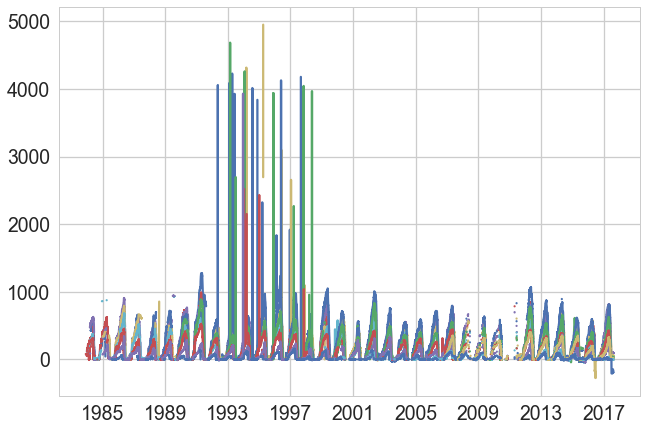

In [17]:
plt.plot(ds.Time_MST,ds.SWE.T.values);

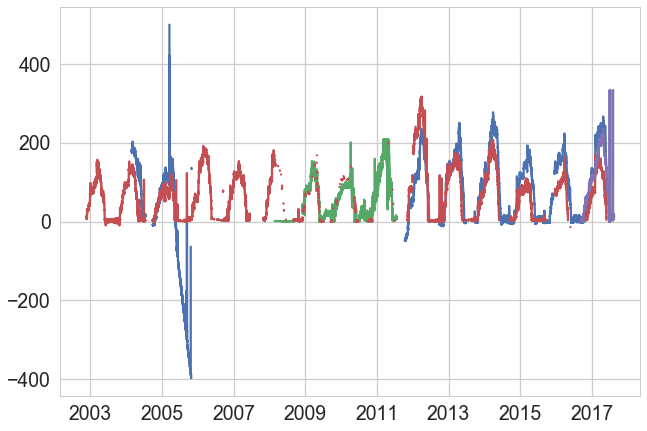

In [18]:
plt.plot(ds.Time_MST,ds.Snowdepth.T.values);

In [19]:
# Adjust time zone to UTC
# MST to UTC (-7 hours)
ds['Time_MST'] = ds.Time_MST + np.timedelta64(-7,'h')
ds.rename({'Time_MST':'Time_UTC'},inplace=True)

<xarray.Dataset>
Dimensions:       (Time_UTC: 315320, staID: 13)
Coordinates:
  * staID         (staID) object '05AA809' '05AA817' '05AD803' '05BB803' ...
  * Time_UTC      (Time_UTC) datetime64[ns] 1983-12-07T04:40:00 ...
    station_name  (staID) object 'Gardiner Creek' 'South Racehorse Creek' ...
    Lat           (staID) float64 49.36 49.78 49.03 51.08 50.63 50.82 50.17 ...
    Lon           (staID) float64 -114.5 -114.6 -114.1 -115.8 -115.3 -115.0 ...
    Elevation     (staID) float64 1.97e+03 1.92e+03 1.761e+03 2.23e+03 ...
Data variables:
    SWE           (staID, Time_UTC) float64 nan nan nan nan nan nan nan nan ...
    Snowdepth     (staID, Time_UTC) float64 nan nan nan nan nan nan nan nan ...

In [20]:
# Add Netowork
ds.coords['network'] = xr.DataArray([c_network for x in ds.staID], dims='staID')

In [21]:
# Save as netcdf file
ds.to_netcdf(netcdf_file_out)